In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, preprocessing
from sklearn.model_selection import train_test_split
from sklearn import cluster
from skmultiflow.drift_detection.adwin import ADWIN

import seaborn as sns

print('pandas =', pd.__version__)
print('numpy =', np.__version__)

# Read data and preprocessing
X1 = pd.read_csv('./data/JNSM_VoD_flashcrowd_1/X.csv').drop(columns=['TimeStamp','Unnamed: 0'])
X2 = pd.read_csv('./data/JNSM_VoD_flashcrowd_2/X.csv').drop(columns=['TimeStamp','Unnamed: 0'])
X = pd.concat([X1,X2])
y1 = pd.read_csv('./data/JNSM_VoD_flashcrowd_1/Y.csv')['DispFrames']
y2 = pd.read_csv('./data/JNSM_VoD_flashcrowd_2/Y.csv')['DispFrames']
y = pd.concat([y1,y2]).to_numpy()
select = np.load('select_VoD.npy')

# X1 = pd.read_csv('./JNSM_KV_flashcrowd_1/X.csv').drop(columns=['TimeStamp','Unnamed: 0'])
# X2 = pd.read_csv('./JNSM_KV_flashcrowd_2/X.csv').drop(columns=['TimeStamp','Unnamed: 0'])
# X = pd.concat([X1,X2])
# y1 = pd.read_csv('./JNSM_KV_flashcrowd_1/Y.csv')['ReadsAvg']
# y2 = pd.read_csv('./JNSM_KV_flashcrowd_2/Y.csv')['ReadsAvg']
# y = pd.concat([y1,y2]).to_numpy()
# select = np.load('select_KV.npy')

del(X1,X2, y1, y2)

# standardization
X = preprocessing.scale(X, axis=0)

pandas = 1.4.4
numpy = 1.23.4


/Users/ruihanzhang/opt/anaconda3/envs/netAna/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


In [2]:
# out-lier removal, 
T = 54 # VoD 54
X_cut = X[(np.abs(X) < T).all(axis=1)]
y_cut = y[(np.abs(X) < T).all(axis=1)]
num = X.shape[0] - X_cut.shape[0]
print('Removed outliers: ', num)
# select top features
X_cut = X_cut[:,select]
print('Selected features: ', len(select))

Removed outliers:  341
Selected features:  16


In [3]:
# our evaluating metric: Normalized Mean Absolute Error
def NMAE(y_true, y_pred):
    return abs(y_true - y_pred).mean() / abs(y_pred).mean()

In [4]:
def rs_update(t0, index, cache):
    rgn = np.random.randint(0, index-t0) # random generated number
    if rgn < len(cache):
        cache[rgn] = index
    return cache

In [319]:
def detect_drift( t, drift_points, ph ):
    # train teacher and student with previous 1000 samples
    X_train = X_cut[t-1000:t,:]
    y_train = y_cut[t-1000:t]
    teacher.fit(X_train, y_train)
    y_teacher = teacher.predict(X_train)
    student.fit(X_train, y_teacher)
    # detect all remainings together
    predict1 = teacher.predict(X_cut[t:,:])
    predict2 = student.predict(X_cut[t:,:])
    loss = np.abs(predict1 - predict2) / predict1
    
    for idx, li in enumerate(loss):
        ph.add_element(li)
        if ph.detected_change():
            drift_points.append(t+idx)
            detect_drift(t+idx , drift_points, ph)
            break # this break is important, ensure we only use the first detected point

In [172]:
def detect_drift_adwin( t, delta=0.002):
    candidates = []
    for i in range(16):
        adwin = ADWIN(delta)
        data_stream = X_cut[t:,i]
        for j in range(len(data_stream)):
            adwin.add_element(data_stream[j])
            if adwin.detected_change():
                # print('Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
                candidates.append(t+j)
    return sorted(candidates)

In [160]:
def elect_adaptive_window( candidates, window_size=50, threshold=28, min_distance=100, delta=0.002):
    current = []
    points = []
    step_count = 0
    for i in range(len(candidates)):
        right = candidates[i]

        if step_count > 0:
            step_count -= 1
            continue

        current.append(right)
        while current[0] < right-window_size: 
            current.pop(0)
        
        if len(current) > threshold:
            points.append(current[0])
            current.clear()
            step_count = min_distance
    return points

In [310]:
# Periodic
drift_points_periodic = [i for i in range(5500, 35000, 2000)]
print(len(drift_points_periodic))

15


In [327]:
# Teacher student
from skmultiflow.drift_detection import PageHinkley
teacher = ensemble.RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42, warm_start=False)
student = ensemble.RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42, warm_start=False)
ph = PageHinkley(min_instances=100 ,delta=0.001 , threshold=7.4)
drift_points_STUDD = []
detect_drift(5500, drift_points_STUDD, ph)
print('detected: {}'.format(len(drift_points_STUDD)))

detected: 15


In [311]:
# ADWIN with kmeans
candidates = detect_drift_adwin(5500)
centers, _, _ = cluster.k_means(np.array(candidates).reshape(-1, 1), n_clusters=15)
drift_points_adwin1 = np.sort(centers.squeeze().astype(int))
print(len(drift_points_adwin1))

15


In [303]:
# ADWIN with our election method
candidates = detect_drift_adwin(5500)

drift_points_adwin2 = elect_adaptive_window(candidates, 50, 29)

# threshold=29, 15 points; threshold=25, 31 points

print(len(drift_points_adwin2))

15


In [336]:
## KV
a = [5500, 7500, 9500, 11500, 13500, 15500, 17500, 19500, 21500, 23500, 25500, 27500]
b = [8973, 11541, 14699, 16446, 16648, 16783, 19397, 21587, 24180, 24330, 24467, 27438]
c = [6599, 8433, 9821, 11242, 13011, 14792, 17016, 19261, 21373, 23007, 24813, 26781]
d = [5723, 7131, 8475, 9595, 11035, 12347, 13691, 14843, 16123, 17403, 19067, 21403, 24091] 

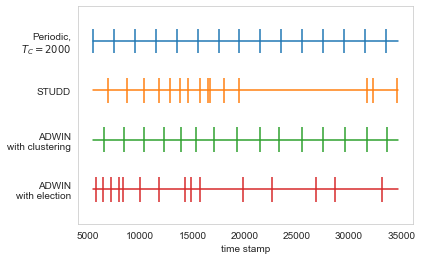

In [372]:
## Compare drift points
data1 = np.random.random([1, 15])
plt.plot([5500,34659], [3,3])
plt.plot([5500,34659], [1,1])
plt.plot([5500,34659], [-1,-1])
plt.plot([5500,34659], [-3,-3])
plt.eventplot(np.arange(5500, 35000, 2000), lineoffsets=3, colors='C0')
plt.eventplot(drift_points_STUDD, lineoffsets=1, colors='C1')
plt.eventplot(drift_points_adwin1, lineoffsets=-1, colors='C2')
plt.eventplot(drift_points_adwin2, lineoffsets=-3, colors='C3')
plt.grid(False)
plt.yticks([3,1,-1,-3], ['Periodic,\n$T_C=2000$','STUDD','ADWIN\nwith clustering','ADWIN\nwith election'])
plt.xlabel('time stamp')
plt.show()

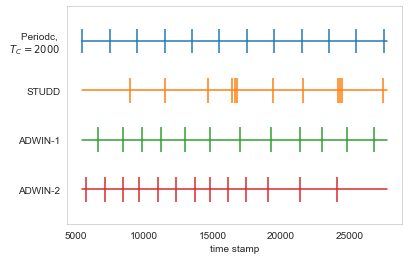

In [338]:
## KV Compare drift points
data1 = np.random.random([1, 15])
plt.plot([5500,27720], [3,3])
plt.plot([5500,27720], [1,1])
plt.plot([5500,27720], [-1,-1])
plt.plot([5500,27720], [-3,-3])
plt.eventplot(a, lineoffsets=3, colors='C0')
plt.eventplot(b, lineoffsets=1, colors='C1')
plt.eventplot(c, lineoffsets=-1, colors='C2')
plt.eventplot(d, lineoffsets=-3, colors='C3')
plt.grid(False)
plt.yticks([3,1,-1,-3], ['Periodc, \n $T_C=2000$','STUDD','ADWIN-1','ADWIN-2'])
plt.xlabel('time stamp')
plt.show()

In [349]:
## ADWIN with k-means clustering
iter = 50
error_1 = np.zeros([4,iter])

for i, n in enumerate([32,128,512,2048]):
    err = []
    for j in range(iter):
        # # initialize
        t0 = np.random.randint(1,5001)
        cache = np.arange(t0, t0+n)
        for t in range(t0+n,t0+3000):
            cache = rs_update(t0, t, cache)

        ## ADWIN detection
        candidates = detect_drift_adwin(t0+3000)
        centers, _, _ = cluster.k_means(np.array(candidates).reshape(-1, 1), n_clusters=15)
        drift_points = np.sort(centers.squeeze().astype(int))

        # first model prediction
        regr = ensemble.RandomForestRegressor(n_estimators=20, n_jobs=-1, warm_start=False)
        regr.fit(X_cut[cache,:], y_cut[cache])

        predictions = regr.predict(X_cut[t0+3000:,:])

        # run model updating
        left = t0+3000
        for right in drift_points:
            # revservoir sampling from current point to next detection point
            for t in range(left,right):
                cache = rs_update(t0, t, cache)
            regr.fit(X_cut[cache,:], y_cut[cache])
            predictions[right-t0-3000:] = regr.predict(X_cut[right:,:])
            left = right
        error_1[i,j] =  NMAE(y_cut[t0+3000:], predictions)
    print('NMAE:{}  for detected: {}'.format(error_1[i,j], drift_points))

NMAE:0.14194133364716202  for detected: [ 8474 10423 12392 14135 15954 17645 19342 21445 23304 25439 27255 29002
 30551 32178 33790]


/Users/ruihanzhang/opt/anaconda3/envs/netAna/lib/python3.8/site-packages/skmultiflow/drift_detection/adwin.py:372: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m
/Users/ruihanzhang/opt/anaconda3/envs/netAna/lib/python3.8/site-packages/skmultiflow/drift_detection/adwin.py:372: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m


NMAE:0.10707993418849042  for detected: [ 5744  8015 10214 12305 14294 16251 18239 19927 21831 23487 25644 27612
 29657 31693 33688]


/Users/ruihanzhang/opt/anaconda3/envs/netAna/lib/python3.8/site-packages/skmultiflow/drift_detection/adwin.py:372: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m


NMAE:0.1273079872965435  for detected: [ 8583 10428 12347 14149 15952 17580 19387 21397 23289 25460 27259 28870
 30375 32102 33801]


/Users/ruihanzhang/opt/anaconda3/envs/netAna/lib/python3.8/site-packages/skmultiflow/drift_detection/adwin.py:372: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m
/Users/ruihanzhang/opt/anaconda3/envs/netAna/lib/python3.8/site-packages/skmultiflow/drift_detection/adwin.py:372: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m


NMAE:0.12342799277739754  for detected: [ 8723 10508 12395 14129 15936 17665 19318 21408 23293 25436 27259 28999
 30505 32130 33791]


In [350]:
## ADWIN with our election method
iter = 50
error_2 = np.zeros([4,iter])

for i, n in enumerate([32,128,512,2048]):
    err = []
    for j in range(iter):
        # # initialize
        t0 = np.random.randint(1,5001)
        cache = np.arange(t0, t0+n)
        for t in range(t0+n,t0+3000):
            cache = rs_update(t0, t, cache)

        ## ADWIN detection
        candidates = detect_drift_adwin(t0+3000)
        drift_points = elect_adaptive_window(candidates, 50, 29)

        # first model prediction
        regr = ensemble.RandomForestRegressor(n_estimators=20, random_state=0, n_jobs=-1)
        regr.fit(X_cut[cache,:], y_cut[cache])

        predictions = regr.predict(X_cut[t0+3000:,:])

        # run model updating
        left = t0+3000
        for right in drift_points:
            # revservoir sampling from current point to next detection point
            for t in range(left,right):
                cache = rs_update(t0, t, cache)
            regr.fit(X_cut[cache,:], y_cut[cache])
            predictions[right-t0-3000:] = regr.predict(X_cut[right:,:])
            left = right
        error_2[i,j] =  NMAE(y_cut[t0+3000:], predictions)
    print('NMAE={}, n={}, t0={},  detected: {} points'.format(error_1[i,j], n, t0, len(drift_points)))

NMAE=0.14194133364716202, n=32, t0=2191,  detected: 18 points


/Users/ruihanzhang/opt/anaconda3/envs/netAna/lib/python3.8/site-packages/skmultiflow/drift_detection/adwin.py:372: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m


NMAE=0.10707993418849042, n=128, t0=1669,  detected: 16 points


/Users/ruihanzhang/opt/anaconda3/envs/netAna/lib/python3.8/site-packages/skmultiflow/drift_detection/adwin.py:372: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m


NMAE=0.1273079872965435, n=512, t0=1534,  detected: 17 points


/Users/ruihanzhang/opt/anaconda3/envs/netAna/lib/python3.8/site-packages/skmultiflow/drift_detection/adwin.py:372: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m
/Users/ruihanzhang/opt/anaconda3/envs/netAna/lib/python3.8/site-packages/skmultiflow/drift_detection/adwin.py:372: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m


NMAE=0.12342799277739754, n=2048, t0=2145,  detected: 12 points


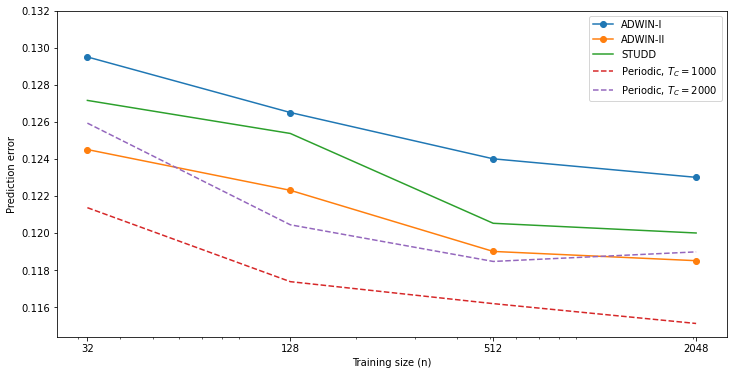

In [17]:
x = [32,128,512,2048]

plt.figure(figsize=(12,6))

plt.plot(x, [0.1295, 0.1265, 0.124, 0.123], '-o', label="ADWIN-I")

plt.plot(x, [0.1245, 0.1223, 0.119, 0.1185], '-o', label="ADWIN-II")

y4 = np.load('T3 100times avg = 16.npy')
plt.plot(x, y4.mean(1), label='STUDD')

y2 = np.load('T1.2.200times.npy').mean(1)
# plt.plot(x, y2, 'k--',label='T1.2')

y3 = np.load('T2.100times.npy')
# plt.plot(x, y3[:,0], label='$T_C = 100$')
# plt.plot(x, y3[:,1], label='$T_C = 200$')
# plt.plot(x, y3[:,2], label='$T_C = 500$')
plt.plot(x, y3[:,3],'--', label='Periodic, $T_C = 1000$')
plt.plot(x, y3[:,4],'--', label='Periodic, $T_C = 2000$')

plt.xscale('log')
plt.xticks(x, ['32','128','512','2048'])
plt.ylabel('Prediction error')
plt.xlabel('Training size (n)')
plt.ylim(top=0.132)
plt.legend()
plt.show()